In [8]:
using LinearAlgebra
using DelimitedFiles
using PyPlot
using Random
using LinearAlgebra
using Statistics
using DCAUtils
using StatsBase
using Distributions
using OhMyThreads
using JLD2

In [10]:
include("energy.jl");
#include("off_MontecarloUtils.jl");
#include("dATline.jl");
include("leo_montecarlo.jl")

ham_dist (generic function with 3 methods)

In [175]:
function initialize_seq(L::Int)

    ### Initialize the spin configuration to a random one
    S = zeros(Int,L)
    for i = 1:L
        if rand() > 0.5
            S[i] = 1
        else
            S[i] = -1
        end
    end
    return S
end

initialize_seq (generic function with 2 methods)

In [191]:
function graph_fixed_mean_conn(L::Int, C::Int, var_J::Float64, var_h::Float64)
    p = Connectivity/(L-1)


    ### Initialize seed RNG
    RNGseed = 10
    Random.seed!(RNGseed)


    ### Initialize fields & couplings
    FieldDistribution = Laplace(0,var_h) 
    h=rand(FieldDistribution, L)  

    J = zeros(Float64,L,L)
    for i = 1:L
        for j = i+1:L
            if rand() < p
                Jvalue = rand(Normal(0,R))
                J[i,j] = Jvalue
                J[j,i] = Jvalue
            end
        end
    end

    for i in 1:L
        for j in 1:L
            @assert J[i,j] == J[j,i]
        end
    end
    
    return h,J
end

    

graph_fixed_mean_conn (generic function with 1 method)

In [192]:
L = 100; C = 4; var_J = 0.25; var_h = 0.25; S = initialize_seq(L); h, J = graph_fixed_mean_conn(L, C, var_J, var_h);

In [ ]:
L = 100; C = 4; var_J = 0.25; var_h = 0.25; S = initialize_seq(L); h, 
J = graph_fixed_mean_conn(L, C, var_J, var_h); Ts = [0.2*i for i in 1:5]; res =[]; for T in Ts
    push!(res, MCMC_Sampling(eq_msa, h, J,β =  1.0/T, N_steps = 10^6, N_chains = 500, N_points = 50));
    end
@save "../save_simulations_VianaBray.jld2" res h J S Ts L C var_J var_h

In [ ]:
@load "../../simulations_VianaBray.jld2"

4-element Vector{Symbol}:
 :res
 :h
 :J
 :S

In [ ]:
L = 100
list = readdlm("../Gen.jl/Viana_Bray/CouplingsFields_Connectivity4_seed10_L100")
J = zeros(L,L)
h = zeros(L)
for n in 1:size(list,1)
    if typeof(list[n,3]) == Float64
        J[list[n,1],list[n,2]] = list[n,3]
        J[list[n,2],list[n,1]] = list[n,3]
    else
        h[list[n,1]] = list[n,2]
    end 
end    

## Simulations from different equilibrium sequences

In [ ]:
L = 100; N_steps = 10^7; N_chains = 500;

S = initialize_seq(L);
start_msa = Int.(hcat([S for i in 1:500]...)');
res_eq = MCMC_Sampling(start_msa, h, J, β =  1., N_steps = 10^6, N_chains = N_chains, N_points = 20);
eq_msa = res_eq.step_msa[end];

Ts = [0.2 + 0.05 * i for i in 1:20]; res = []; for T in Ts
    push!(res, MCMC_Sampling(eq_msa, h, J,β =  1.0/T, N_steps = N_steps, N_chains = N_chains, N_points = 10^4));
    end
@save "../big_save_simulations_VianaBray.jld2" res h J S Ts L C var_J var_h


steps = res[1].times
N = length(steps)

hams = []
ens = []
for i in 1:length(Ts)
    push!(hams, [ham_dist(res[i].step_msa[1], x) for x in res[i].step_msa])
    push!(ens, [compute_energy(h,J,x) for x in res[i].step_msa])
end

z_min = minimum(Ts)
z_max = maximum(Ts)
normalized_Ts = [(z - z_min) / (z_max - z_min) for z in Ts]

# Generate a color map (viridis in this case)
cmap = get_cmap("viridis")
colors = [cmap(z) for z in normalized_Ts]

close("all")
plt.plot()
for i in 1:length(Ts)
    plt.plot(steps, [mean(hams[i][n]) for n in 1:N], color=colors[i], label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Mean Hamming Distance")
plt.savefig("../mean_ham_dist.png")

close("all")
plt.plot()
for i in 1:length(Ts)
    plt.plot(steps, L^2 .* [var(hams[i][n]) for n in 1:N], color=colors[i], label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Var Hamming Distance")
plt.savefig("../var_ham_dist.png")

close("all")
plt.plot()
for i in 1:length(Ts)
    plt.plot(steps, [mean(ens[i][n]) for n in 1:N], color=colors[i], label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Mean Energy")
plt.savefig("../mean_energy.png")

close("all")
plt.plot()
for i in 1:length(Ts)
    plt.plot(steps, [var(ens[i][n]) for n in 1:N], color=colors[i], label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Var Energy")
plt.savefig("../var_energy.png")


N = length(steps)
close("all")
plt.plot()
for tw in Int.([N/3, N/2, N])
    plt.plot(Ts, [mean([var(ens[i][t])/(Ts[i]*Ts[i]) for t in tw-50:tw]) for i in 1:length(Ts)], label = "tw = $(steps[tw])")
end
plt.legend()
plt.xlabel("T")
plt.ylabel("Specific Heat")
plt.savefig("../specific_heat.png")


close("all")
plt.plot()
for tw in Int.([N/3, N/2, N])
    plt.plot(Ts, L^2 .* [mean([var(hams[i][t]) for t in tw-50:tw]) for i in 1:length(Ts)], label = "tw = $(steps[tw])")
end
plt.legend()
plt.xlabel("T")
plt.ylabel("Final Var Hamming")
plt.savefig("../final_var_ham_dist.png")


close("all")
plt.plot()
for i in [1, 7, 15]
    plt.plot(steps[100:5000] .- steps[100], [mean(x) for x in hams_delayed1[i]], color=colors[i], linewidth = 0.1, linestyle = ":",label = "T = $(round(Ts[i], digits = 2)) t_w = 10^2")
    plt.plot(steps[1000:5000] .- steps[1000], [mean(x) for x in hams_delayed2[i]], color=colors[i], linewidth = 1., linestyle = "--", label = "T = $(round(Ts[i], digits = 2)) t_w = 10^3")
    plt.plot(steps[2400:5000] .- steps[2400], [mean(x) for x in hams_delayed3[i]], color=colors[i], linewidth = 5., linestyle = "-.", label = "T = $(round(Ts[i], digits = 2)) t_w = 10^4")
end


plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Mean Hamming Distance")
plt.savefig("../delayed_mean_ham_dist.png")


close("all")
plt.plot()

for i in [1,7,15]
    plt.plot(steps, L^2 .* [var(hams[i][n]) for n in 1:N], color=colors[i],  alpha = 0.5, label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Var Hamming Distance")
plt.savefig("../small_var_ham_dist.png")



## Simulations from same equilibrium sequence

In [ ]:


L = 100;  N_chains = 500;

S = initialize_seq(L);
start_msa = Int.(hcat([S for i in 1:500]...)');
res_eq = MCMC_Sampling(start_msa, h, J, β =  1., N_steps = 10^6, N_chains = N_chains, N_points = 20);
eq_msa = Int.(hcat([res_eq.step_msa[end][10,:] for i in 1:500]...)');

N_steps = 10^7; Ts = [0.2 + 0.05 * i for i in 1:20]; res = []; for T in Ts
    push!(res, MCMC_Sampling(eq_msa, h, J,β =  1.0/T, N_steps = N_steps, N_chains = N_chains, N_points = 10^4));
    end
@save "../big_save_simulations_VianaBray.jld2" res h J S Ts L C var_J var_h


steps = res[1].times
N = length(steps)

hams = []
ens = []
for i in 1:length(Ts)
    push!(hams, [ham_dist(res[i].step_msa[1], x) for x in res[i].step_msa])
    push!(ens, [compute_energy(h,J,x) for x in res[i].step_msa])
end

z_min = minimum(Ts)
z_max = maximum(Ts)
normalized_Ts = [(z - z_min) / (z_max - z_min) for z in Ts]

# Generate a color map (viridis in this case)
cmap = get_cmap("viridis")
colors = [cmap(z) for z in normalized_Ts]

close("all")
plt.plot()
for i in 1:length(Ts)
    plt.plot(steps, [mean(hams[i][n]) for n in 1:N], color=colors[i], label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Mean Hamming Distance")
plt.savefig("../mean_ham_dist.png")

close("all")
plt.plot()
for i in 1:length(Ts)
    plt.plot(steps, L^2 .* [var(hams[i][n]) for n in 1:N], color=colors[i], label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Var Hamming Distance")
plt.savefig("../var_ham_dist.png")

close("all")
plt.plot()
for i in 1:length(Ts)
    plt.plot(steps, [mean(ens[i][n]) for n in 1:N], color=colors[i], label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Mean Energy")
plt.savefig("../mean_energy.png")

close("all")
plt.plot()
for i in 1:length(Ts)
    plt.plot(steps, [var(ens[i][n]) for n in 1:N], color=colors[i], label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Var Energy")
plt.savefig("../var_energy.png")


N = length(steps)
close("all")
plt.plot()
for tw in Int.([N/3, N/2, N])
    plt.plot(Ts, [mean([var(ens[i][t])/(Ts[i]*Ts[i]) for t in tw-50:tw]) for i in 1:length(Ts)], label = "tw = $(steps[tw])")
end
plt.legend()
plt.xlabel("T")
plt.ylabel("Specific Heat")
plt.savefig("../specific_heat.png")


close("all")
plt.plot()
for tw in Int.([N/3, N/2, N])
    plt.plot(Ts, L^2 .* [mean([var(hams[i][t]) for t in tw-50:tw]) for i in 1:length(Ts)], label = "tw = $(steps[tw])")
end
plt.legend()
plt.xlabel("T")
plt.ylabel("Final Var Hamming")
plt.savefig("../final_var_ham_dist.png")


hams_delayed1 = []; hams_delayed2 = []; hams_delayed3 = [];
for i in 1:length(Ts)
    push!(hams_delayed1, [ham_dist(res[i].step_msa[100], x) for x in res[i].step_msa[100:5000]])
    push!(hams_delayed2, [ham_dist(res[i].step_msa[1000], x) for x in res[i].step_msa[1000:5000]])
    push!(hams_delayed3, [ham_dist(res[i].step_msa[2400], x) for x in res[i].step_msa[2400:5000]])
end

close("all")
plt.plot()
for i in [1, 7, 15]
    plt.plot(steps[100:5000] .- steps[100], [mean(x) for x in hams_delayed1[i]], color=colors[i], linewidth = 0.1, linestyle = ":",label = "T = $(round(Ts[i], digits = 2)) t_w = 10^2")
    plt.plot(steps[1000:5000] .- steps[1000], [mean(x) for x in hams_delayed2[i]], color=colors[i], linewidth = 1., linestyle = "--", label = "T = $(round(Ts[i], digits = 2)) t_w = 10^3")
    plt.plot(steps[2400:5000] .- steps[2400], [mean(x) for x in hams_delayed3[i]], color=colors[i], linewidth = 5., linestyle = "-.", label = "T = $(round(Ts[i], digits = 2)) t_w = 10^4")
end


plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Mean Hamming Distance")
plt.savefig("../delayed_mean_ham_dist.png")


close("all")
plt.plot()

for i in [1,7,15]
    plt.plot(steps, L^2 .* [var(hams[i][n]) for n in 1:N], color=colors[i],  alpha = 0.5, label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Var Hamming Distance")
plt.savefig("../small_var_ham_dist.png")


## Mpemba Effect

In [ ]:
L = 100; 

S = initialize_seq(L);
start_msa = Int.(hcat([S for i in 1:500]...)');
Ts = [1.0 + 1.0*i for i in 1:10];
res_eq = [];
for T in Ts
    push!(res_eq, MCMC_Sampling(start_msa, h, J, β =  1. /T, 
            N_steps = 10^5, N_chains = 500, N_points = 20));
end
eq_msa = [res_eq[i].step_msa[end] for i in 1:10];

res = []
T_0 = 1.0
N_chains = 500;
N_steps = 10^5; 
for i in 1:length(Ts)
    push!(res, MCMC_Sampling(eq_msa[i], h, J, β =  1. /T_0, 
            N_steps = N_steps, N_chains = N_chains, N_points = 10^3));
end

    
  
steps = res[1].times
N = length(steps)

hams = []
ens = []
for i in 1:length(Ts)
    push!(hams, [ham_dist(res[i].step_msa[1], x) for x in res[i].step_msa])
    push!(ens, [compute_energy(h,J,x) for x in res[i].step_msa])
end

z_min = minimum(Ts)
z_max = maximum(Ts)
normalized_Ts = [(z - z_min) / (z_max - z_min) for z in Ts]

# Generate a color map (viridis in this case)
cmap = get_cmap("viridis")
colors = [cmap(z) for z in normalized_Ts]

close("all")
plt.plot()
for i in 1:length(Ts)
    plt.plot(steps, [mean(hams[i][n]) for n in 1:N], color=colors[i], label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Mean Hamming Distance")
plt.savefig("../mean_ham_dist.png")

close("all")
plt.plot()
for i in 1:length(Ts)
    plt.plot(steps, L^2 .* [var(hams[i][n]) for n in 1:N], color=colors[i], label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Var Hamming Distance")
plt.savefig("../var_ham_dist.png")

close("all")
plt.plot()
for i in 1:length(Ts)
    plt.plot(steps, [mean(ens[i][n]) for n in 1:N], color=colors[i], label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Mean Energy")
plt.savefig("../mean_energy.png")

close("all")
plt.plot()
for i in 1:length(Ts)
    plt.plot(steps, [var(ens[i][n]) for n in 1:N], color=colors[i], label = "T = $(round(Ts[i], digits = 2))")
end

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("Var Energy")
plt.savefig("../var_energy.png")




## look at phase transition wiht naive tap

In [84]:
function tap_update!(m::Array{Float64,1}, h::Array{Float64,1}, J::Matrix{Float64}, L::Int, T::Float64)
    sum = 0
    for i in 1:L
        sum = h[i]
        for j in 1:L
            sum += J[i,j]*m[j] - (m[i]*J[i,j]*J[i,j]*(1-m[j]*m[j]))
        end
        m[i] = tanh(sum/T)
    end
    
end
    
function tap(h::Array{Float64,1}, J::Matrix{Float64}, T::Float64; n_steps = 100)
    L = length(h)
    res = Matrix{Float64}(undef, n_steps, L)
    m = rand(L)
    for n in 1:n_steps
        tap_update!(m, h, J, L, T)
        for i in 1:L
            res[n,i] = m[i]
        end
    end
    
    return res
end   

tap (generic function with 1 method)

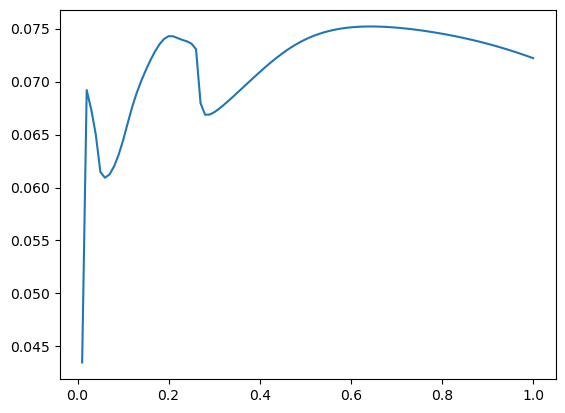

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f09b47e5640>

In [125]:
L = 100; C = 4; var_h = 1.; var_J = 0.25; var_h = h, J = graph_fixed_mean_conn(L, C, var_J, var_h);
res = []; Ts = [1e-2* i for i in 1:100];
for T in Ts
    push!(res,tap(h, J, T))
end
plt.plot(Ts, [mean(res[i][end,:]) for i in 1:length(Ts)])